In [46]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
import itertools
from pmdarima import auto_arima

from parser.resident_new_loans import get_new_loans_resident
from parser.resident_loans_volume import get_loans_volume_resident
from data_transform.transform_df import transform_df_to_format
from parser.loans_volume_msp import get_measures

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

# Резиденты, объем задолженностей, региональный разрез

In [47]:
regions = get_measures()

In [48]:
def mape( actual , pred ): 
    actual, pred = np.array(actual), np.array(pred)
    actual_safe = np.where(actual == 0, 1e-10, actual)
    return np.mean(np.abs((actual - pred) / actual_safe))*100

In [79]:
def region_predict_debt(key, value, split_date, trend):
    # временная заглушка
    df = transform_df_to_format(get_loans_volume_resident(measure_id=key, spike_remove=True, window_size=3, sigma=2))
    # Извлекаем год из столбца "Отчетный период"
    df['date'] = df['Отчетный период'].str.extract(r'(\d{4})').astype(int)
    # Формируем новый столбец "Дата" в формате YYYY-MM
    df['date'] = df['date'].astype(str) + '-' + df['month_n'].astype(str)
    df['date'] = pd.to_datetime(df['date'])
    # Удаляем временные столбцы
    df = df[['date', 'resident_new_loans']]
    df = df.reset_index()
    df = df.drop('index', axis = 1)
    n = df.index[df['date'] == split_date]
    train_size = n[0]
    test_size = len(df) - train_size
    train = df[df['date']<split_date]
    test = df[df['date']>=split_date]
    # Делаем из датафреймов серии
    trn_ser = train.copy()
    trn_ser.set_index(keys='date', drop=True, inplace=True)
    trn_ser = trn_ser.squeeze(axis=1)
    tst_ser = test.copy()
    tst_ser.set_index(keys='date', drop=True, inplace=True)
    tst_ser = tst_ser.squeeze(axis=1)
    # Подбор параметров
    parameter_search = auto_arima(trn_ser, start_p = 1, start_q = 1, max_p = 3, max_q = 3, m = 12, start_P = 0, seasonal = True, trend = trend,
                         d = None, D = 1, trace = True, error_action ='ignore', suppress_warnings = True,  stepwise = True, with_intercept=True) 
    s_ord = parameter_search.seasonal_order
    pdq = parameter_search.order
    # ОБУЧЕНИЕ МОДЕЛИ
    model = SARIMAX(trn_ser, order=pdq, seasonal_order=s_ord , measurement_error=True, enforce_stationarity=True, enforce_invertibility=True ) 
    model_fit = model.fit() 
    pred = model_fit.get_prediction(start=split_date, end='2026-03-01', dynamic=False)
    vol_diff_pred = pred.predicted_mean
    test_pred = vol_diff_pred[0:test_size]
    mp = mape(tst_ser.values, test_pred.values)
    print(mp)
    print("\nСпрогнозированные значения:")
    print(vol_diff_pred)
    plt.figure(figsize=(12, 4))
    plt.plot(df['date'], df['resident_new_loans'].values/1e6)
    plt.plot(vol_diff_pred/1e6)
    plt.xlabel('date')
    plt.ylabel('Резиденты - объем задолженностей по кредитам, трлн руб.')
    plt.title(value)
    plt.grid(True)
    plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12] intercept   : AIC=1090.650, Time=0.29 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=1084.798, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=1087.860, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=1089.964, Time=0.06 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1084.798, Time=0.01 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=1086.724, Time=0.10 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1086.726, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=1088.694, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=1085.916, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=1087.991, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[12] intercept   : AIC=1088.756, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.895 seconds
7.77131112484333

Спрогнозированные значения:
2023-05-01    2.822918e+07
2023-06-01    2.791477e+07
2023-07-01    2.803688e+07
2023-08-01    2

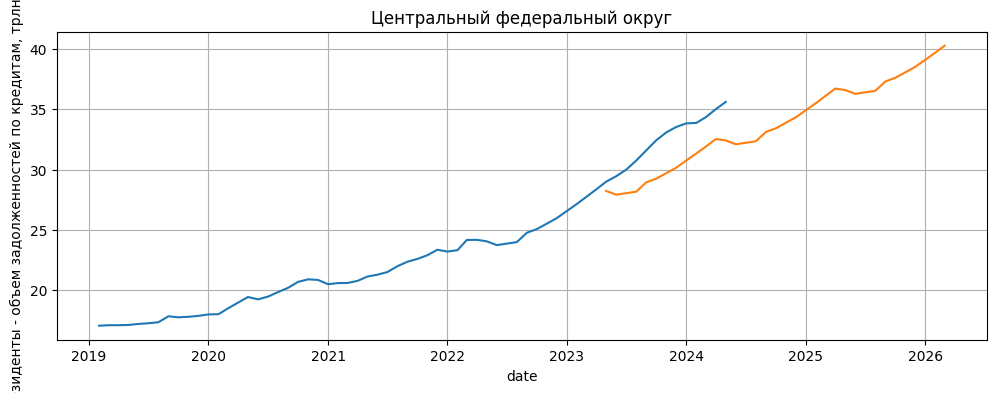

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12] intercept   : AIC=991.420, Time=0.34 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=986.572, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=989.629, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=989.433, Time=0.10 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=986.572, Time=0.03 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=988.623, Time=0.15 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=988.596, Time=0.07 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=990.361, Time=0.16 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=987.718, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=987.520, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[12] intercept   : AIC=989.480, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12] intercept
Total fit time: 1.185 seconds
8.108079358538964

Спрогнозированные значения:
2023-05-01    6.827772e+06
2023-06-01    6.754873e+06
2023-07-01    6.715580e+06
2023-08-01    6.741381e+0

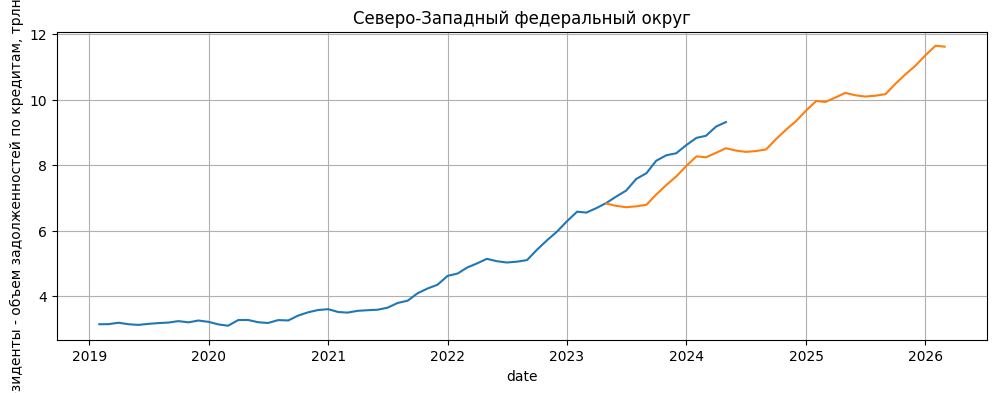

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12] intercept   : AIC=953.850, Time=0.20 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=947.497, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=951.661, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=951.763, Time=0.10 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=947.497, Time=0.03 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=950.200, Time=0.06 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=950.204, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=951.515, Time=0.33 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=949.682, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=949.777, Time=0.11 sec
 ARIMA(1,1,1)(0,1,0)[12] intercept   : AIC=951.865, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 1.177 seconds
2.395368606944647

Спрогнозированные значения:
2023-05-01    3.079948e+06
2023-06-01    3.029432e+06
2023-07-01    3.020210e+06
2023-08-01    3.115660e+0

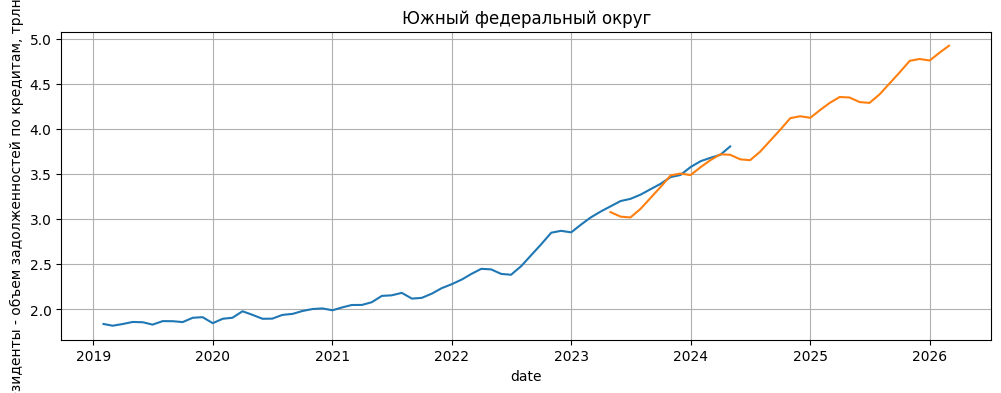

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12] intercept   : AIC=956.105, Time=0.18 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=957.347, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=955.419, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=955.733, Time=0.08 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=957.347, Time=0.01 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=953.709, Time=0.04 sec
 ARIMA(1,1,0)(0,1,1)[12] intercept   : AIC=955.410, Time=0.29 sec
 ARIMA(1,1,0)(1,1,1)[12] intercept   : AIC=957.370, Time=0.42 sec
 ARIMA(2,1,0)(0,1,0)[12] intercept   : AIC=953.817, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[12] intercept   : AIC=954.445, Time=0.14 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=954.046, Time=0.03 sec
 ARIMA(2,1,1)(0,1,0)[12] intercept   : AIC=954.865, Time=0.27 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=953.709, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12] intercept
Total fit time: 1.728 seconds
8.887265263778731

Сп

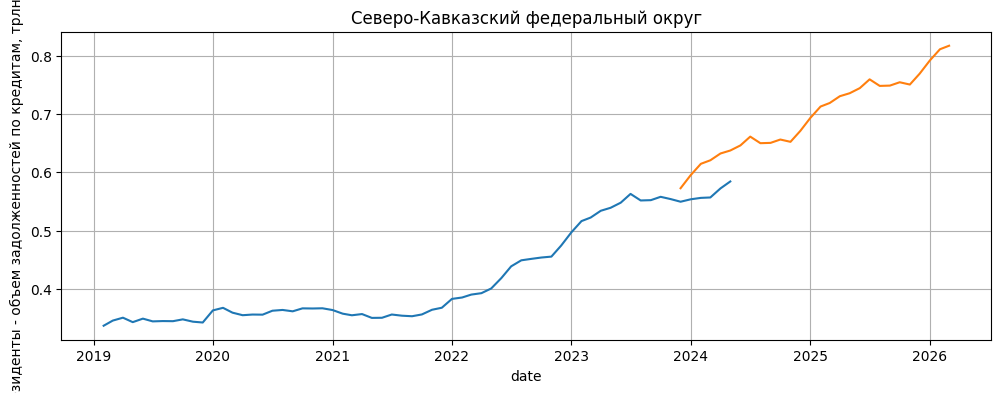

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12] intercept   : AIC=1142.093, Time=0.31 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=1134.846, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=1141.361, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=1141.302, Time=0.11 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1134.846, Time=0.01 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=1136.788, Time=0.05 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1136.788, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=1138.788, Time=0.34 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=1139.548, Time=0.05 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=1139.503, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12] intercept   : AIC=1140.171, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 1.220 seconds
2.084008624530316

Спрогнозированные значения:
2023-12-01    5.287003e+06
2024-01-01    5.266397e+06
2024-02-01    5.270835e+06
2024-03-01    

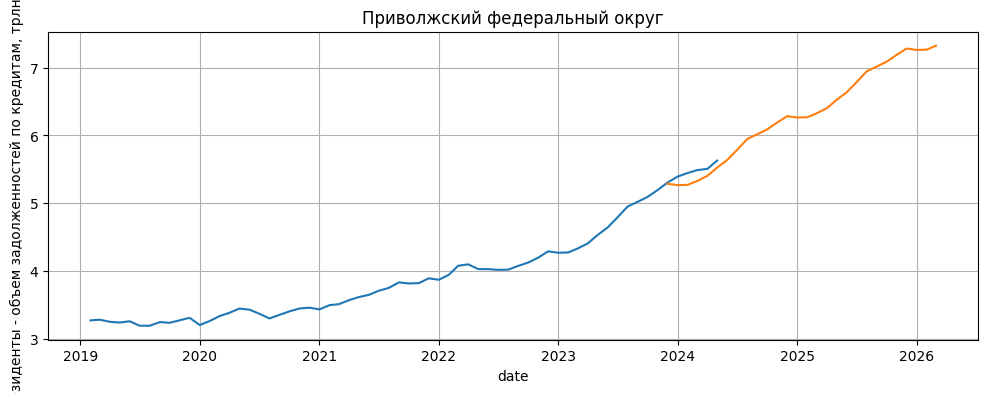

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12] intercept   : AIC=977.837, Time=0.44 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=972.358, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=975.687, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=975.908, Time=0.11 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=972.358, Time=0.02 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=974.013, Time=0.05 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=973.997, Time=0.08 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=975.929, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=974.030, Time=0.05 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=974.239, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12] intercept   : AIC=976.181, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12] intercept
Total fit time: 1.177 seconds
5.286283228860747

Спрогнозированные значения:
2023-05-01    4.725579e+06
2023-06-01    4.618016e+06
2023-07-01    4.669901e+06
2023-08-01    4.731207e+0

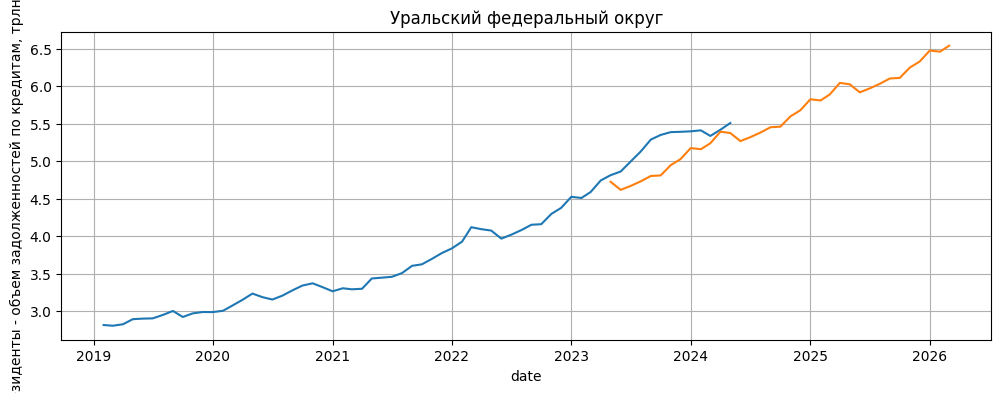

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12] intercept   : AIC=1157.509, Time=0.27 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=1153.066, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=1155.702, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=1155.687, Time=0.08 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1153.066, Time=0.02 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=1154.734, Time=0.05 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1154.737, Time=0.09 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=1156.733, Time=0.29 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=1153.956, Time=0.05 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=1153.920, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12] intercept   : AIC=1155.700, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12] intercept
Total fit time: 1.035 seconds
2.994257110799159

Спрогнозированные значения:
2023-12-01    3.405314e+06
2024-01-01    3.374733e+06
2024-02-01    3.368165e+06
2024-03-01    

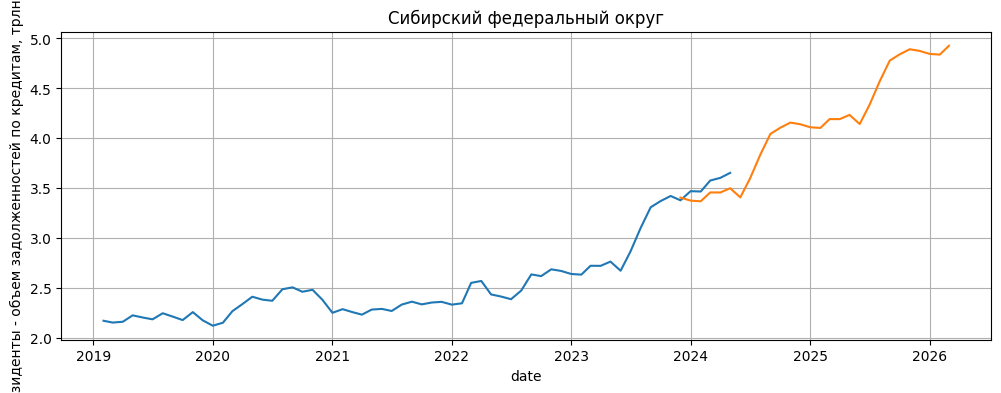

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1364.158, Time=0.61 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1284.353, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1342.239, Time=0.33 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1259.591, Time=0.08 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1284.353, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1263.298, Time=0.03 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=1261.087, Time=0.16 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=1261.477, Time=0.16 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1263.304, Time=0.25 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=1262.948, Time=0.27 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1275.392, Time=0.06 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=1259.740, Time=0.09 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1256.208, Time=0.54 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(1,1,1)[12]

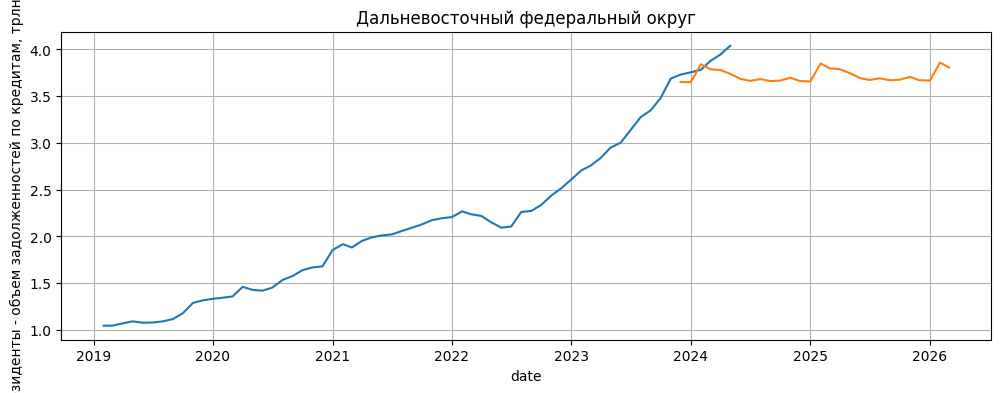

In [82]:
for key,value in regions.items():
    if key in [23, 42, 55, 87]:
        region_predict_debt(key, value, '2023-05', 'ct')
    if key in [64, 72, 95, 106]:
        region_predict_debt(key, value, '2023-12', 'c')

# Резиденты, объем задолженностей, временной разрез

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12] intercept   : AIC=1118.141, Time=0.47 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=1113.736, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=1117.301, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=1117.364, Time=0.14 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1113.736, Time=0.02 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=1115.714, Time=0.07 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1115.714, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=1117.714, Time=0.21 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=1115.341, Time=0.07 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=1115.414, Time=0.06 sec
 ARIMA(1,1,1)(0,1,0)[12] intercept   : AIC=1116.147, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12] intercept
Total fit time: 1.462 seconds
8.558699385194837

Спрогнозированные значения:
2023-05-01    5.294853e+07
2023-06-01    5.232740e+07
2023-07-01    5.265558e+07
2023-08-01    

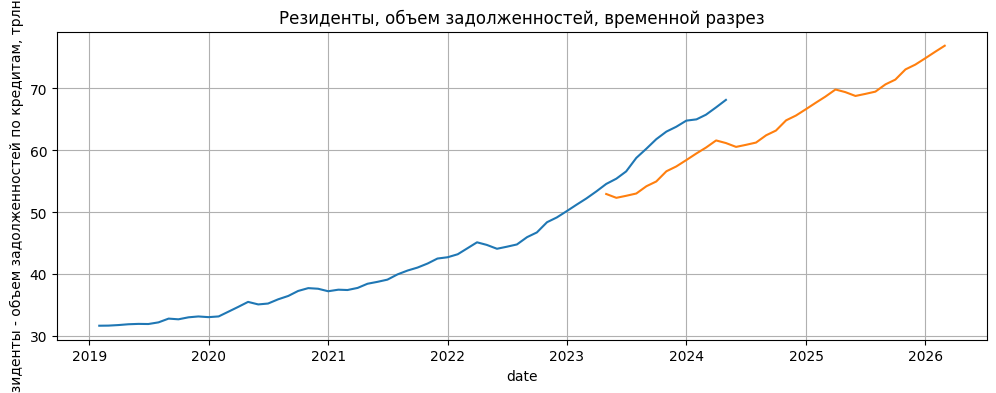

In [64]:
region_predict_debt(22, 'Резиденты, объем задолженностей, временной разрез', '2023-05')

# Резиденты объем кредитов региональный разрез

In [72]:
def region_predict_loan(key, value, trend):
    # временная заглушка
    df = transform_df_to_format(get_new_loans_resident(measure_id=key, spike_remove=True, window_size=3, sigma=2))
    # Извлекаем год из столбца "Отчетный период"
    df['date'] = df['Отчетный период'].str.extract(r'(\d{4})').astype(int)
    # Формируем новый столбец "Дата" в формате YYYY-MM
    df['date'] = df['date'].astype(str) + '-' + df['month_n'].astype(str)
    df['date'] = pd.to_datetime(df['date'])
    # Удаляем временные столбцы
    df = df[['date', 'resident_loans_volume']]
    df = df.reset_index()
    df = df.drop('index', axis = 1)
    split_date = '2023-07'
    n = df.index[df['date'] == split_date]
    train_size = n[0]
    test_size = len(df) - train_size
    train = df[df['date']<split_date]
    test = df[df['date']>=split_date]
    # Делаем из датафреймов серии
    trn_ser = train.copy()
    trn_ser.set_index(keys='date', drop=True, inplace=True)
    trn_ser = trn_ser.squeeze(axis=1)
    tst_ser = test.copy()
    tst_ser.set_index(keys='date', drop=True, inplace=True)
    tst_ser = tst_ser.squeeze(axis=1)
    # Подбор параметров
    parameter_search = auto_arima(trn_ser, start_p = 1, start_q = 1, max_p = 3, max_q = 3, m = 12, start_P = 0, seasonal = True, trend = trend,
                         d = None, D = 1, trace = True, error_action ='ignore', suppress_warnings = True,  stepwise = True, with_intercept=True) 
    s_ord = parameter_search.seasonal_order
    pdq = parameter_search.order
    # ОБУЧЕНИЕ МОДЕЛИ
    model = SARIMAX(trn_ser, order=pdq, seasonal_order=s_ord, measurement_error=True, enforce_stationarity=True, enforce_invertibility=True ) 
    model_fit = model.fit() 
    pred = model_fit.get_prediction(start=split_date, end='2026-03-01', dynamic=False)
    vol_diff_pred = pred.predicted_mean
    test_pred = vol_diff_pred[0:test_size]
    mp = mape(tst_ser.values, test_pred.values)
    print(mp)
    print("\nСпрогнозированные значения:")
    print(vol_diff_pred)
    plt.figure(figsize=(12, 4))
    plt.plot(df['date'], df['resident_loans_volume'].values/1e6)
    plt.plot(vol_diff_pred/1e6)
    plt.xlabel('date')
    plt.ylabel('Резиденты - объем кредитов, трлн руб.')
    plt.title(value)
    plt.grid(True)
    plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12] intercept   : AIC=1201.482, Time=0.15 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=1199.404, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=1200.475, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=1199.955, Time=0.08 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1199.404, Time=0.02 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=1200.183, Time=0.06 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1207.959, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=1199.405, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=1199.357, Time=0.03 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   : AIC=1200.226, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,1,1)(0,1,0)[12] intercept   : AIC=1200.972, Time=0.18 sec
 ARIMA(0,1,2)(0,1,0)[12] intercept   : AIC=1199.560, Time=0.04 sec
 ARIMA(1,1,2)(0,1,0)[12] inte

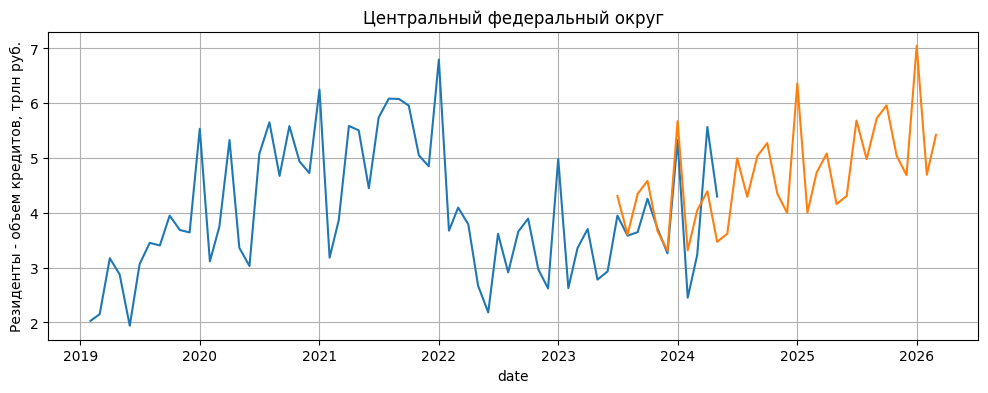

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1079.325, Time=0.29 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1096.899, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1082.020, Time=7.67 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1094.034, Time=0.21 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1096.899, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1090.504, Time=0.05 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=1076.556, Time=0.35 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1075.269, Time=0.15 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1077.118, Time=0.44 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=1078.195, Time=1.31 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1092.665, Time=0.11 sec
 ARIMA(2,0,1)(1,1,0)[12] intercept   : AIC=1075.360, Time=0.35 sec
 ARIMA(1,0,2)(1,1,0)[12] intercept   : AIC=1077.801, Time=0.37 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1097.570, Time=0.06 sec
 ARIMA(0,0,2)(1,1,0

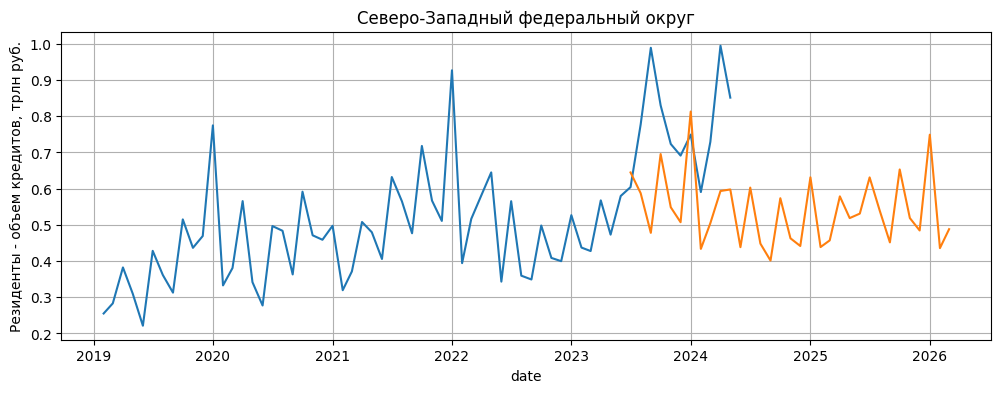

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1008.357, Time=0.31 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1031.518, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1006.202, Time=0.09 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1013.860, Time=0.08 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1031.518, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1009.884, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1008.201, Time=0.20 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1008.200, Time=0.28 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1006.623, Time=0.07 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1010.202, Time=0.26 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1029.857, Time=0.11 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1008.256, Time=0.15 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1007.898, Time=0.15 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1013.351, Time=0.07 sec
 ARIMA(2,0,1)(1,1,0

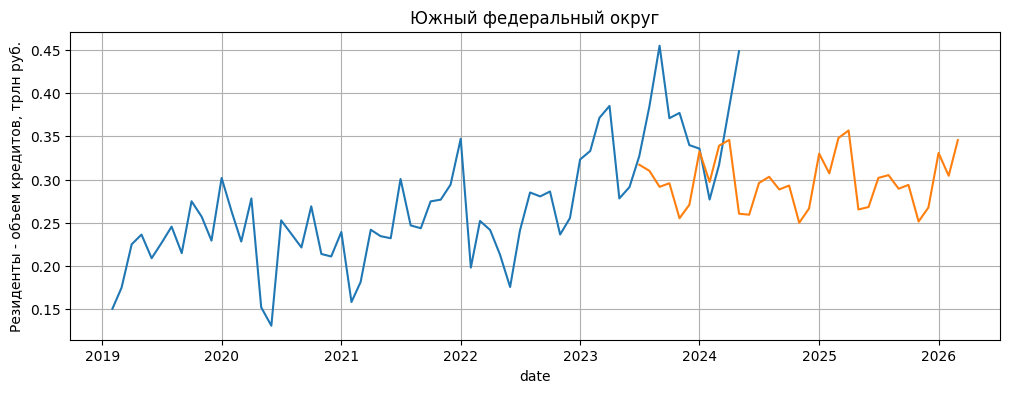

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12] intercept   : AIC=861.810, Time=0.28 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=879.501, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=862.789, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=860.814, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=879.501, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=872.618, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=859.588, Time=0.28 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   : AIC=857.905, Time=0.16 sec
 ARIMA(0,1,1)(2,1,0)[12] intercept   : AIC=859.745, Time=0.25 sec
 ARIMA(0,1,1)(2,1,1)[12] intercept   : AIC=861.156, Time=0.41 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=865.534, Time=0.08 sec
 ARIMA(1,1,1)(1,1,0)[12] intercept   : AIC=859.289, Time=0.57 sec
 ARIMA(0,1,2)(1,1,0)[12] intercept   : AIC=858.793, Time=0.17 sec
 ARIMA(1,1,2)(1,1,0)[12] intercept   : AIC=859.175, Time=0.46 sec
 ARIMA(0,1,1)(1,1,0)[12]         

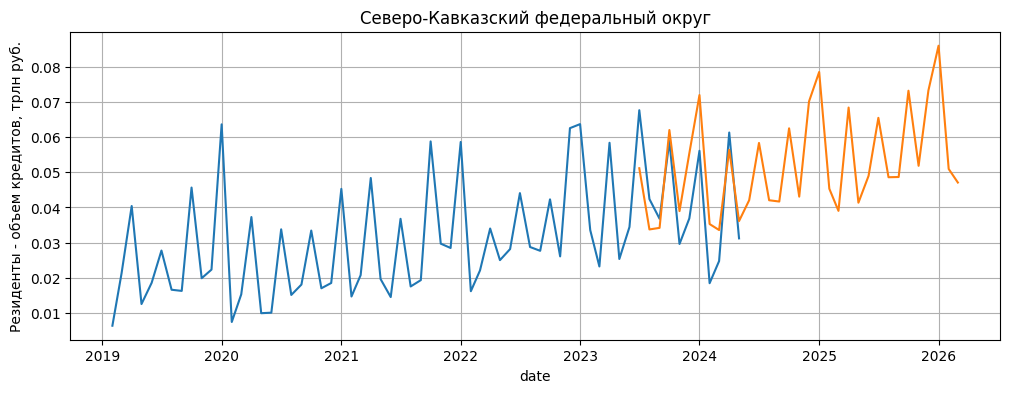

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1043.795, Time=0.17 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1046.719, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1041.743, Time=0.13 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1042.918, Time=0.09 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1046.719, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1041.963, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1040.244, Time=0.24 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1040.959, Time=0.48 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1041.717, Time=0.20 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1042.335, Time=0.15 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1042.352, Time=0.32 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1041.981, Time=0.58 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1040.340, Time=0.65 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=inf, Time=1.84 sec
 ARIMA(1,0,0)(2,1,0)[12]

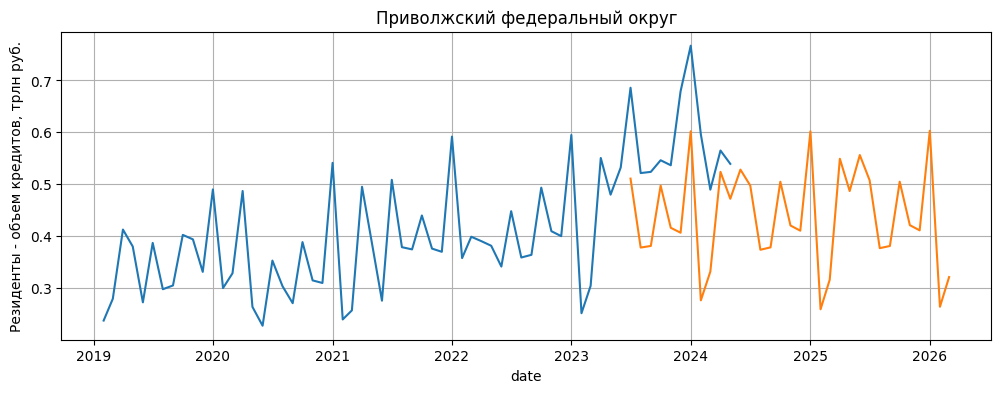

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1041.314, Time=0.31 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1055.162, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1050.565, Time=0.08 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1054.020, Time=0.08 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1055.162, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1055.790, Time=0.10 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=1040.991, Time=0.47 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1039.305, Time=0.23 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1041.067, Time=1.18 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=1042.929, Time=2.43 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1052.164, Time=0.11 sec
 ARIMA(2,0,1)(1,1,0)[12] intercept   : AIC=1039.282, Time=0.34 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=1056.124, Time=0.10 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=1040.783, Time=0.89 sec
 ARIMA(2,0,1)(1,1,1

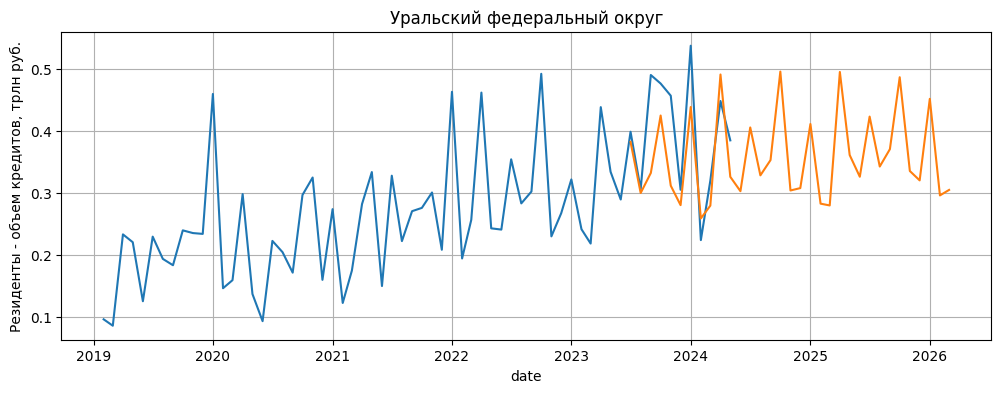

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1012.554, Time=0.33 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1033.256, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1025.293, Time=0.13 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1028.712, Time=0.12 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1033.256, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1030.798, Time=0.09 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=1013.773, Time=0.79 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=1013.394, Time=0.55 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1015.636, Time=0.18 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=1015.250, Time=0.72 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1026.833, Time=0.38 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=1014.561, Time=0.38 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=1016.007, Time=0.52 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1036.187, Time=0.07 sec
 ARIMA(0,0,2)(0,1,1

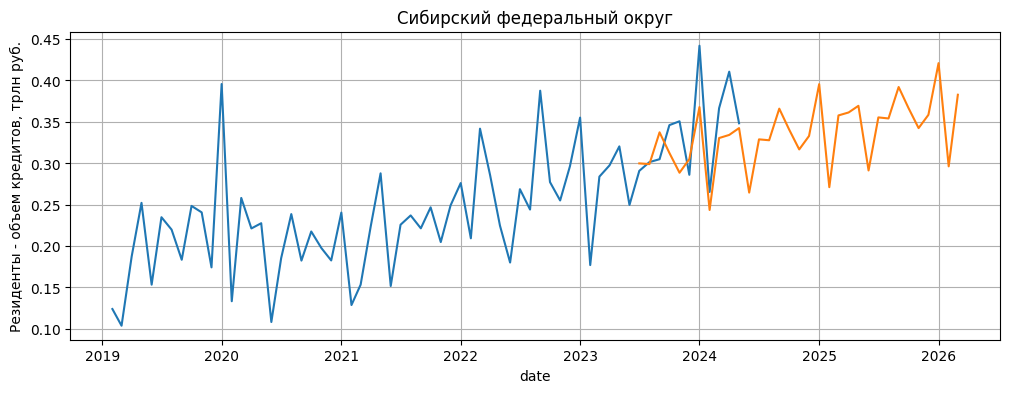

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1030.669, Time=0.30 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1027.229, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1028.483, Time=0.09 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1028.679, Time=0.09 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1027.229, Time=0.02 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1027.985, Time=0.09 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1028.966, Time=0.07 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1026.914, Time=0.04 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1028.505, Time=0.12 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=1028.886, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1028.994, Time=0.13 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1027.019, Time=0.04 sec
 ARIMA(2,0,1)(0,1,0)[12] inte

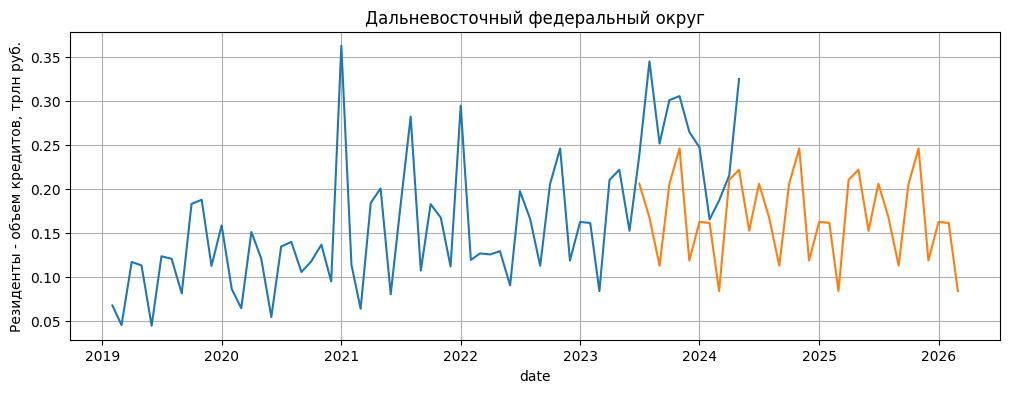

In [74]:
for key,value in regions.items():
    if key in [23, 42, 55, 64, 72, 87, 95, 106]:
        region_predict_loan(key, value, 'n')

# Резиденты объем кредитов временной разрез

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12] intercept   : AIC=1242.139, Time=0.30 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=1237.209, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=1239.878, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=1239.860, Time=0.15 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1237.209, Time=0.02 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=1239.045, Time=0.08 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1239.000, Time=0.21 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=1236.453, Time=0.38 sec
 ARIMA(0,1,0)(2,1,1)[12] intercept   : AIC=1236.869, Time=0.47 sec
 ARIMA(0,1,0)(1,1,2)[12] intercept   : AIC=1237.378, Time=0.42 sec
 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=1237.719, Time=0.32 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=1240.431, Time=0.38 sec
 ARIMA(0,1,0)(2,1,2)[12] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(1,1,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,1,1)(1,1,1)[12] inte

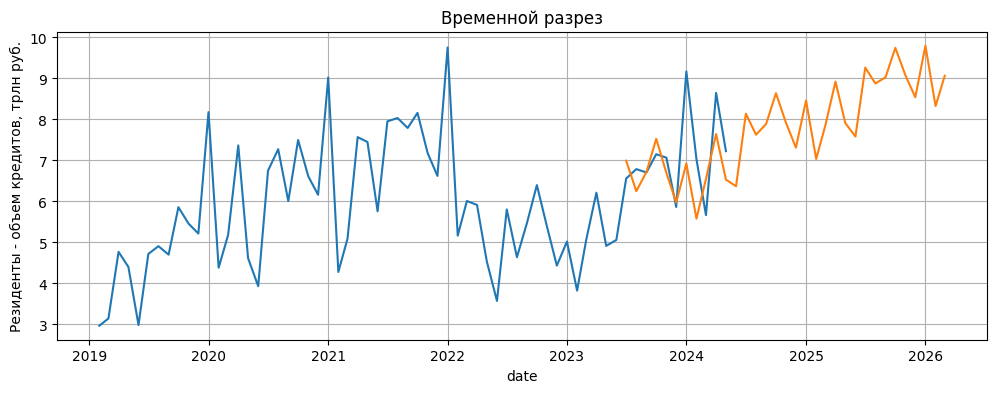

In [73]:
region_predict_loan(22, 'Временной разрез', 'ct')